In [1]:
from scipy.spatial.transform import Rotation as R
import subprocess
import matplotlib.pyplot as plot
import numpy
import sys
from optparse import OptionParser
import math
import copy
import random
now_meeted_robot = ['robot1']
self_robot_name = ['robot2']
name_list = self_robot_name + now_meeted_robot
#input self robot vertex pose ,other robot vertex pose, estimation
input = [['robot1', 'robot2', [-0.006730081486720601, 0.005200751282662849, 0.05322883600355548], [-0.008784756995737553, 0.000971187895629555, -0.17183305323123932], [0.49563478638442526, -0.5033143859224182, -0.027092493820423037]], ['robot1', 'robot2', [2.5685985455518647, 0.041095590996776434, -0.20847167067797334], [2.5013318061828613, 0.23931951820850372, 13.264532089233398], [-2.095990243066181, -0.5380569629591935, 0.578820349859655]]]

#给定一个较为精确初值情况下，研究PGO是否正确
new_input = []
# init_guess_center = [-7 * pow(2,0.5) * math.cos(25/180*math.pi),7 * pow(2,0.5) * math.sin(25/180*math.pi),0]
init_guess_center = [-7,-7,0]
for now_input in input:
    now_vertex = now_input[3]
    tmp = []
    theta = init_guess_center[2]/180*math.pi
    tmp.append(math.cos(theta) * now_vertex[0] - math.sin(theta) * now_vertex[1] + init_guess_center[0])
    tmp.append(math.sin(theta) * now_vertex[0] + math.cos(theta) * now_vertex[1] + init_guess_center[1])
    tmp.append(theta + now_vertex[2])
    now_input[3] = tmp
    new_input.append(now_input)
input = new_input
estimate_real = []

for now_input in input:
    now_est = now_input[4]
    tmp = []
    theta = now_input[2][2]/180*math.pi
    tmp.append(math.cos(theta) * now_est[0] - math.sin(theta) * now_est[1] + now_input[2][0])
    tmp.append(math.sin(theta) * now_est[0] + math.cos(theta) * now_est[1] + now_input[2][1])
    tmp.append(theta + now_est[2])
    estimate_real.append(tmp)
estimate_real = numpy.array(estimate_real) #估计的节点位置在世界坐标系下的坐标


robot2_est_world = [] #估计得到的机器人位姿在世界坐标系下位置
robot2_yaw_est_world = []

for now_input in input:
    rota_mat = []
    trans = []
    for i in range(3):
        now_yaw = now_input[i+2][2]/180*math.pi
        now_trans = numpy.array([now_input[i+2][0],now_input[i+2][1]])
        now_rot = numpy.array([[numpy.cos(now_yaw), -numpy.sin(now_yaw)],[numpy.sin(now_yaw),numpy.cos(now_yaw)]])
        rota_mat.append(now_rot)
        trans.append(now_trans)
    yaw_est_mat = rota_mat[0] @ rota_mat[2] @ rota_mat[1].T
    yaw_est = math.atan2(yaw_est_mat[0,1],yaw_est_mat[0,0])
    trans_est = rota_mat[0] @ (rota_mat[2] @ ( - rota_mat[1].T @ trans[1]) + trans[2]) + trans[0]
    robot2_est_world.append(trans_est)
    robot2_yaw_est_world.append(yaw_est)

# now_meeted_robot = ['robot1']
# self_robot_name = ['robot2']
# name_list = self_robot_name + now_meeted_robot
# input =  [['robot2', 'robot1', [-0.0011728304364084386, 0.003723924394819929, 0.05933554019269594], [-0.003479321487247944, 0.0015267840353772044, -0.03461313620209694], [0.544768604965521, -0.8986373766179356, 29.302346582113138]]]
pose_origin1 = numpy.array([],float).reshape((2,-1))
pose_origin2 = numpy.array([],float).reshape((2,-1))

c_real = [[0,0,0],init_guess_center]

trust1 = 1
trust2 = 100

now_id = 1
trans_data = ""
for center in c_real:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(now_id,center[0],center[1],center[2]/180*math.pi)
    if now_id == 1:
        pose_origin1 = numpy.append(pose_origin1, numpy.array([[center[0]],[center[1]]]), axis=1)
    else:
        pose_origin2 = numpy.append(pose_origin2, numpy.array([[center[0]],[center[1]]]), axis=1)
    now_id +=1

for now_input in input:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(now_id,now_input[2][0],now_input[2][1],now_input[2][2]/180*math.pi)
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(now_id+1,now_input[3][0],now_input[3][1],now_input[3][2]/180*math.pi)
    pose_origin1 = numpy.append(pose_origin1, numpy.array([[now_input[2][0]],[now_input[2][1]]]), axis=1)
    pose_origin2 = numpy.append(pose_origin2, numpy.array([[now_input[3][0]],[now_input[3][1]]]), axis=1)

    start_idx = str(name_list.index(now_input[0])+1)
    end_idx = str(name_list.index(now_input[1])+1)
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(start_idx, now_id,now_input[2][0],now_input[2][1],now_input[2][2]/180*math.pi,trust2,trust2,trust2)
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(end_idx, now_id+1,now_input[3][0],now_input[3][1],now_input[3][2]/180*math.pi,trust2,trust2,trust2)
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(start_idx,end_idx,now_input[4][0],now_input[4][1],now_input[4][2]/180*math.pi,trust1,trust1,trust1)
    now_id += 2


print(trans_data)
process = subprocess.Popen("./pose_graph_2d", stdin=subprocess.PIPE, stdout=subprocess.PIPE, text=True)
# 向C++程序输入数据
process.stdin.write(trans_data)
# 关闭输入流
process.stdin.close()
output_data = process.stdout.read()
# 等待C++程序退出
process.wait()

output_data = output_data[:-1]

print(output_data)

rows = output_data.split('\n')
# 将每行分割成字符串数组
data_list = [row.split() for row in rows]
# 将字符串数组转换为浮点数数组
data_arr = numpy.array(data_list, dtype=float)
poses_optimized = data_arr[:,1:]
poses_optimized[:,-1] = poses_optimized[:,-1] / math.pi *180#转换到角度制度
print("\npose optimized \n",poses_optimized)
print(R.from_euler('z', poses_optimized[1][2], degrees=True).as_matrix())

VERTEX_SE2 1 0.000000 0.000000 0.000000
VERTEX_SE2 2 -7.000000 -7.000000 0.000000
VERTEX_SE2 3 -0.006730 0.005201 0.000929
VERTEX_SE2 4 -7.008785 -6.999029 -0.002999
EDGE_SE2 2 3 -0.006730 0.005201 0.000929 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 1 4 -7.008785 -6.999029 -0.002999 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 2 1 0.495635 -0.503314 -0.000473 1.000000 0 0 1.000000 0 1.000000
VERTEX_SE2 5 2.568599 0.041096 -0.003639
VERTEX_SE2 6 -4.498668 -6.760680 0.231510
EDGE_SE2 2 5 2.568599 0.041096 -0.003639 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 1 6 -4.498668 -6.760680 0.231510 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 2 1 -2.095990 -0.538057 0.010102 1.000000 0 0 1.000000 0 1.000000




F0627 11:14:27.612622 698797 problem_impl.cc:482] Parameter block not found: 0x55fb7f2e1238. You must add the parameter block to the problem before it can be set constant.
*** Check failure stack trace: ***


IndexError: index -1 is out of bounds for axis 1 with size 0

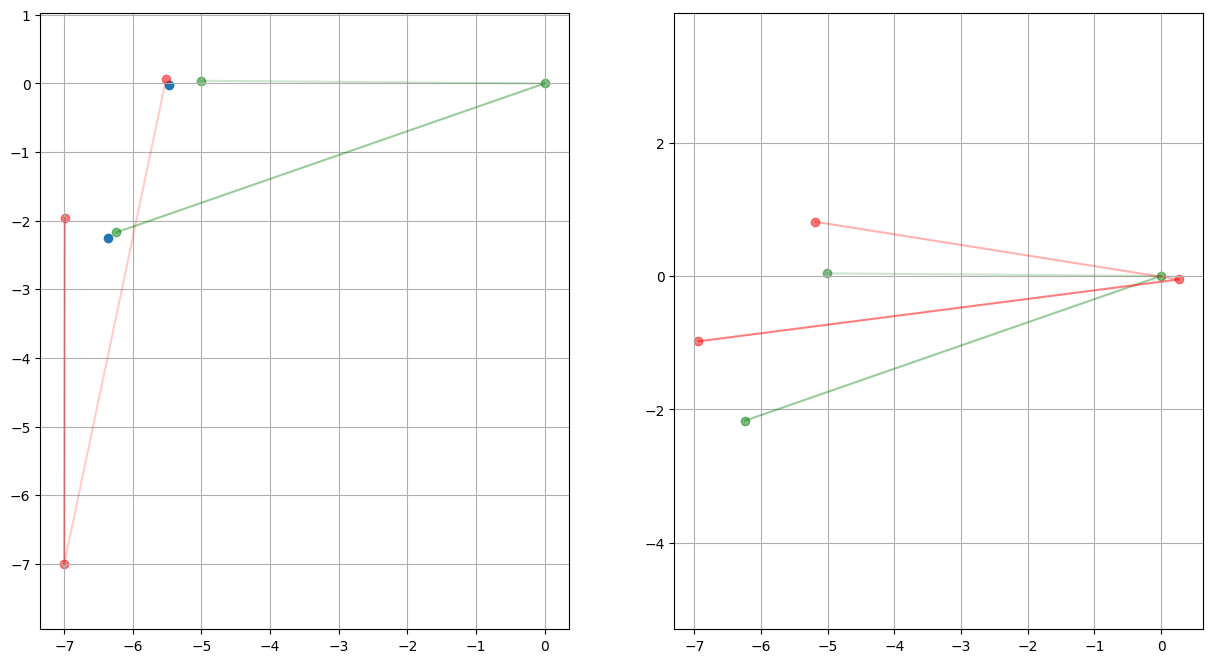

In [29]:
import matplotlib.pyplot as plot
import numpy as np
import sys

# Read the original and optimized poses files.


rows = output_data.split('\n')
# 将每行分割成字符串数组
data_list = [row.split() for row in rows]
# 将字符串数组转换为浮点数数组
data_arr = np.array(data_list, dtype=float)

poses_optimized = data_arr[:,1:-1]
# Plots the results for the specified poses.
plot.figure(figsize=(15,8))

plot.subplot(121)
plot.scatter(estimate_real[:,0],estimate_real[:,1])
plot.scatter(pose_origin1[0,:], pose_origin1[1,:],alpha=0.5, color="green")
for i in range(1,pose_origin1.shape[1]):
    plot.plot([pose_origin1[0,0],pose_origin1[0,i]], [pose_origin1[1,0],pose_origin1[1,i]],alpha=i/5, color="green")
plot.scatter(pose_origin2[0,:], pose_origin2[1,:],alpha=0.5, color="red")
for i in range(1,pose_origin2.shape[1]):
    plot.plot([pose_origin2[0,0],pose_origin2[0,i]], [pose_origin2[1,0],pose_origin2[1,i]],alpha=i/5, color="red")
plot.axis('equal')
plot.grid()

# figure2
plot.subplot(122)
plot.scatter(poses_optimized[0,0], poses_optimized[0,1],alpha=0.5, color="green")

for i in range(2,pose_origin1.shape[1]*2,2):
    plot.scatter(poses_optimized[i,0], poses_optimized[i,1],alpha=0.5, color="green")
    plot.plot([poses_optimized[0,0],poses_optimized[i,0]], [poses_optimized[0,1],poses_optimized[i,1]],alpha=i/10, color="green")

plot.scatter(poses_optimized[1,0], poses_optimized[1,1],alpha=0.5, color="red")
for i in range(3,pose_origin1.shape[1]*2,2):
    plot.scatter(poses_optimized[i,0], poses_optimized[i,1],alpha=0.5, color="red")
    plot.plot([poses_optimized[1,0],poses_optimized[i,0]], [poses_optimized[1,1],poses_optimized[i,1]],alpha=i/10, color="red")
plot.grid()
plot.axis('equal')
# Show the plot and wait for the user to close.
plot.show()
